# Imports

In [ ]:
if 'google.colab' in str(get_ipython()):
  try:
    import torchbearer
  except:
    !pip install piq torchbearer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# general --------------------------------------
import os
import sys
import tarfile
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt



# Image processing -----------------------------
import cv2
from piq import ssim, psnr
from skimage.draw import rectangle
from skimage.util import random_noise


# pytorch --------------------------------------
import torch
import torchbearer
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets

# Download data

In [ ]:
imagenette = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
ftpstream = urllib.request.urlopen(imagenette)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall()
train_loc_imagenette = './imagenette2-160/train'
val_loc_imagenette = './imagenette2-160/val'



imagewoof = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"
ftpstream = urllib.request.urlopen(imagewoof)
thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
thetarfile.extractall()
train_loc_imagewoof = './imagewoof2-160/train'
val_loc_imagewoof = './imagewoof2-160/val'

In [ ]:
try:
  os.mkdir('output')
  os.mkdir('output/plots')
  os.mkdir('output/weights')
except:
  pass

# Custom Transforms to add noise to images

In [ ]:
class gaussianNoise():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        tensor += torch.randn(tensor.size())*self.std + self.mean # add gaussian noise
        tensor = torch.clip(tensor, 0, 1) # clip values to ensure the tensor values are in range [0,1]
        return tensor

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean}, std={self.std})"
        return repr
    
class poissonNoise():
    def __init__(self, c):
        self.c = c # magnitude parameter descibed in section 2.3

    def __call__(self, tensor):
        tensor = torch.poisson(tensor / self.c) * self.c # add poisson noise
        tensor = torch.clip(tensor, 0, 1)
        return tensor

    def __repr__(self):
        repr = f"{self.__class__.__name__  }"
        return repr
    

class speckleNoise():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        tensor *= (1 + torch.randn(tensor.size())*self.std + self.mean) # multiplicative gaussian noise
        tensor = torch.clip(tensor, 0, 1)
        return tensor

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean}, std={self.std})"
        return repr
    
class spNoise():
    def __init__(self, amount = 0.05, s_vs_p = 0.5):
        self.amount = amount
        self.s_vs_p = s_vs_p

    def __call__(self, tensor):
        tensor = torch.tensor(random_noise(tensor, mode = 's&p', amount = self.amount, salt_vs_pepper = self.s_vs_p)) # add salt and pepper noise
        return tensor

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(amount={self.amount}, s_vs_p={self.s_vs_p})"
        return repr
    

class occlusionNoise():
    def __init__(self, rel_side):
        print('Occlusion noise class may not be implemented correctly, use with caution!')
        self.rel_side = rel_side

    def __call__(self, tensor):
        rows = self.rel_side * tensor.shape[1] # vertical length of occulsion
        cols = self.rel_side * tensor.shape[2] # horizontal length of occulsion
#         start_x = np.random.randint(0, tensor.shape[1]-rows) # randomise location of the occulsion
#         start_y = np.random.randint(0, tensor.shape[2]-cols) # randomise location of the occulsion
        start_y = 0 # start at the first column of pixels
        start_x = tensor.shape[2] - rows # start at the last row of pixels
        r, c = rectangle(start = (start_x,start_y), extent = (rows, cols), shape = tensor.shape[1:]) # generate mask
        tensor[:,r,c] = 0 # create the occlusion
        return tensor

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(relative side length={self.rel_side}"
        return repr

In [ ]:
def createTransforms(shape, var_gauss, var_speck,  amount, svp, scale_factor, relative_side):
    
    gaussian = transforms.Compose([
        transforms.Resize(shape), # resize any input to be height: 100px, width: 100px
        transforms.ToTensor(), # transform the image into a tensor
        gaussianNoise(0, np.sqrt(var_gauss)) # add gaussian noise with specified mean and standard deviation
    ])

    speckle = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        speckleNoise(0, np.sqrt(var_speck)) # add speckle noise with specified mean and standard deviation
    ])

    sp = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        spNoise(amount, svp) # apply salt & pepper noise with specified prop. of pixels to be corrupted + split of salt and pepper
    ])

    poisson = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        poissonNoise(scale_factor) # add poisson noise with a specified magnitude factor
    ])

    occlusion = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
        occlusionNoise(relative_side) # add a black square with relative side lengths specfied, starting at the bottom left of the image
    ])

    noNoise = transforms.Compose([
        transforms.Resize(shape),
        transforms.ToTensor(),
    ])
    
    return gaussian, speckle, sp, poisson, occlusion, noNoise
    

# Figure 1

## transforms

In [ ]:
gaussianT, speckleT, spT, poissonT, occlusionT, noNoiseT = createTransforms((100,100), 0.2, 0.2, 0.05, 0.5, 0.2, 0.3)

Occlusion noise class may not be implemented correctly, use with caution!


## datasets and dataloaders

In [ ]:
noNoiseDataset = datasets.ImageFolder(train_loc_imagewoof, noNoiseT) # dataset object for the specified images
gaussianDataset = datasets.ImageFolder(train_loc_imagewoof, gaussianT)
speckleDataset = datasets.ImageFolder(train_loc_imagewoof, speckleT)
spDataset = datasets.ImageFolder(train_loc_imagewoof, spT)
poissonDataset = datasets.ImageFolder(train_loc_imagewoof, poissonT)
occlusionDataset = datasets.ImageFolder(train_loc_imagewoof, occlusionT)

noNoiseTrainloader = DataLoader(noNoiseDataset, batch_size = 100, shuffle = False)
gaussianTrainloader = DataLoader(gaussianDataset, batch_size = 100, shuffle = False)
speckleTrainloader = DataLoader(speckleDataset, batch_size = 100, shuffle = False)
spTrainloader = DataLoader(spDataset, batch_size = 100, shuffle = False)
poissonTrainloader = DataLoader(poissonDataset, batch_size = 100, shuffle = False)
occlusionTrainloader = DataLoader(occlusionDataset, batch_size = 100, shuffle = False)

## SSIM and PSNR

In [ ]:
ssim_gauss = torch.Tensor([]) # empty tensors, will be joined in the below loop
psnr_gauss = torch.Tensor([])

ssim_speck = torch.Tensor([])
psnr_speck = torch.Tensor([])

ssim_sp = torch.Tensor([])
psnr_sp = torch.Tensor([])

ssim_poiss = torch.Tensor([])
psnr_poiss = torch.Tensor([])

ssim_occ = torch.Tensor([])
psnr_occ = torch.Tensor([])

# loop over all the Dataloader objects similtaneously
for clean, gauss, speck, sp, poiss, occ in tqdm(zip(noNoiseTrainloader, gaussianTrainloader,
                                               speckleTrainloader, spTrainloader, poissonTrainloader, occlusionTrainloader)):
    
    # concatenate the empty tensors with the calculated ssim and psnr tensors
    psnr_gauss = torch.cat((psnr_gauss, psnr(clean[0], gauss[0], data_range=1.0, reduction = 'none')))
    ssim_gauss = torch.cat((ssim_gauss, ssim(clean[0], gauss[0], data_range=1.0, reduction = 'none')))
    
    psnr_speck = torch.cat((psnr_speck, psnr(clean[0], speck[0], data_range=1.0, reduction = 'none')))
    ssim_speck = torch.cat((ssim_speck, ssim(clean[0], speck[0], data_range=1.0, reduction = 'none')))
    
    psnr_sp = torch.cat((psnr_sp, psnr(clean[0], sp[0], data_range=1.0, reduction = 'none')))
    ssim_sp = torch.cat((ssim_sp, ssim(clean[0], sp[0], data_range=1.0, reduction = 'none')))
    
    psnr_poiss = torch.cat((psnr_poiss, psnr(clean[0], poiss[0], data_range=1.0, reduction = 'none')))
    ssim_poiss = torch.cat((ssim_poiss, ssim(clean[0], poiss[0], data_range=1.0, reduction = 'none')))
    
    psnr_occ = torch.cat((psnr_occ, psnr(clean[0], occ[0], data_range=1.0, reduction = 'none')))
    ssim_occ = torch.cat((ssim_occ, ssim(clean[0], occ[0], data_range=1.0, reduction = 'none')))
    

## Plots

In [ ]:
def drawJoinPlot(ssim, psnr, s, letter):
  g=sns.jointplot(x=ssim, y=psnr, kind='hex')
  plt.xlabel('SSIM')
  plt.ylabel('PSNR')
  plt.gca().xaxis.set_label_coords(1.12, -0.01)
  plt.gca().yaxis.set_label_coords(1.01, 0.5)
  # plt.text(x=0.5, y=20.1, s=letter + ') ' + s, horizontalalignment='center', fontsize=18)

  plt.savefig('output/plots/ssim_psnr_' + s + '.pdf')

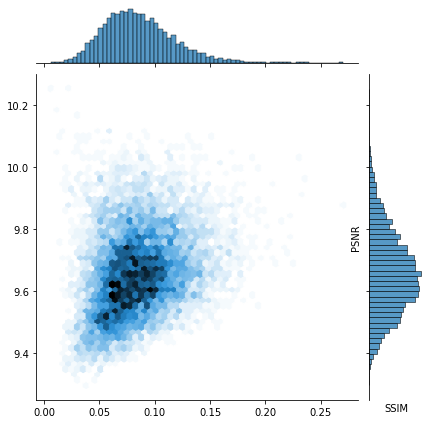

In [ ]:
drawJoinPlot(ssim_gauss, psnr_gauss, 'Gaussian', 'a')

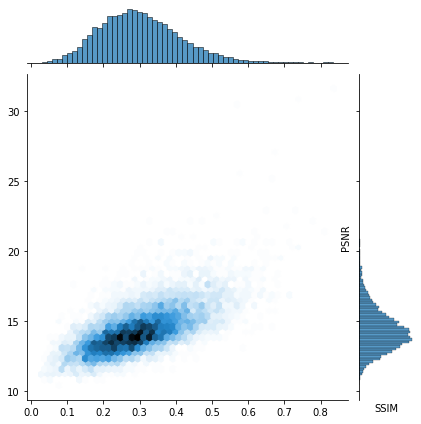

In [ ]:
drawJoinPlot(ssim_speck, psnr_speck, 'Speckle', 'b')

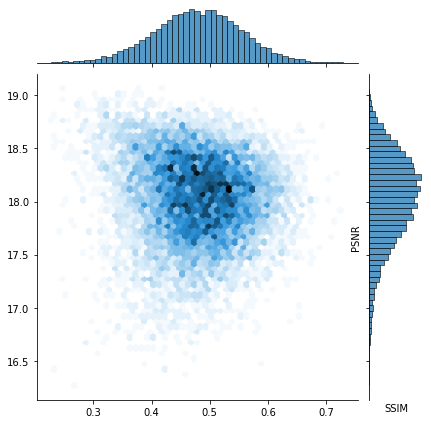

In [ ]:
drawJoinPlot(ssim_sp, psnr_sp, 'S&P', 'c')

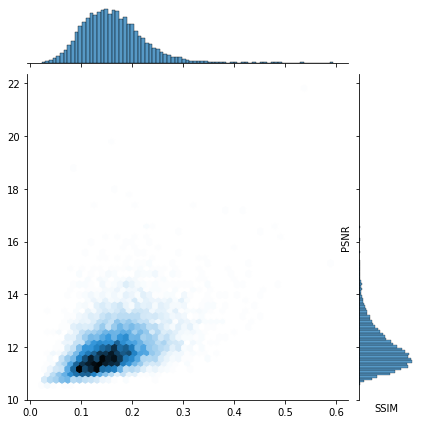

In [ ]:
drawJoinPlot(ssim_poiss, psnr_poiss, 'Poisson', 'd')

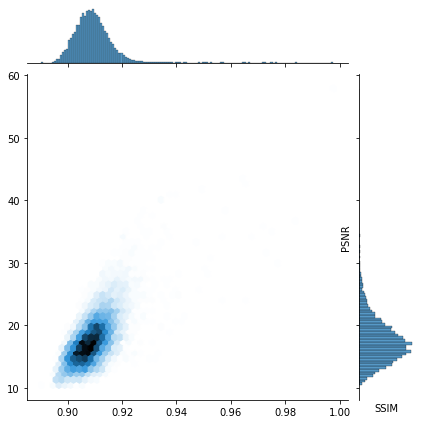

In [ ]:
drawJoinPlot(ssim_occ, psnr_occ, 'Occlusion', 'e')

# Table 1

## calculate kurtosis

In [ ]:
ssim_gauss_kurt = stats.kurtosis(ssim_gauss) # calculate the kurtosis of the similarity measure
psnr_gauss_kurt = stats.kurtosis(psnr_gauss)

ssim_speck_kurt = stats.kurtosis(ssim_speck)
psnr_speck_kurt = stats.kurtosis(psnr_speck)

ssim_sp_kurt = stats.kurtosis(ssim_sp)
psnr_sp_kurt = stats.kurtosis(psnr_sp)

ssim_poiss_kurt = stats.kurtosis(ssim_poiss)
psnr_poiss_kurt = stats.kurtosis(psnr_poiss)

ssim_occ_kurt = stats.kurtosis(ssim_occ)
psnr_occ_kurt = stats.kurtosis(psnr_occ)

kurts = np.array([['Gaussian', 'SSIM', ssim_gauss_kurt],
 ['Speckle','SSIM', ssim_speck_kurt],
 ['S&P','SSIM', ssim_sp_kurt],
 ['Poisson','SSIM', ssim_poiss_kurt],
['Occlusion', 'SSIM', ssim_occ_kurt],
['Gaussian', 'PSNR', psnr_gauss_kurt],
 ['Speckle','PSNR', psnr_speck_kurt],
 ['S&P','PSNR', psnr_sp_kurt],
 ['Poisson','PSNR', psnr_poiss_kurt],
['Occlusion', 'PSNR', psnr_occ_kurt]]) # put similarity measures into an array

kurts_df = pd.DataFrame(kurts, columns = ['Noise','Type', 'Kurtosis']) # convert to a DataFram object
kurts_df['Kurtosis'] = kurts_df['Kurtosis'].astype(float) # cast the kurtosis to a floating point number
kurts_df['Noise'] = kurts_df['Noise'].map({'Gaussian': '1. Gaussian', 'Speckle': '2. Speckle', 'S&P': '3. S&P', 'Poisson': '4. Poisson', 'Occlusion': '5. Occlusion'})

kurts_pt = kurts_df.pivot_table(values = 'Kurtosis', columns = ['Noise','Type']) # pivot table to resemble Table 1 in paper

## table

In [ ]:
try:
  import dataframe_image as dfi
except:
  !pip install dataframe_image
  import dataframe_image as dfi

     |████████████████████████████████| 1.3MB 11.5MB/s 
     |████████████████████████████████| 143kB 38.0MB/s 
     |████████████████████████████████| 296kB 38.5MB/s 


In [ ]:
dfi.export(kurts_pt, './pivot.png', table_conversion='matplotlib')
round(kurts_pt, 3)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


Noise    1. Gaussian        2. Speckle  ... 4. Poisson 5. Occlusion        
Type            PSNR   SSIM       PSNR  ...       SSIM         PSNR    SSIM
Kurtosis        0.05  0.665      6.265  ...      1.693        4.396  14.364

[1 rows x 10 columns]

In [ ]:
print(round(kurts_pt, 3).to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
Noise & \multicolumn{2}{l}{1. Gaussian} & \multicolumn{2}{l}{2. Speckle} & \multicolumn{2}{l}{3. S\&P} & \multicolumn{2}{l}{4. Poisson} & \multicolumn{2}{l}{5. Occlusion} \\
Type &        PSNR &   SSIM &       PSNR &   SSIM &   PSNR &   SSIM &       PSNR &   SSIM &         PSNR &    SSIM \\
\midrule
Kurtosis &        0.05 &  0.665 &      6.265 &  0.319 &  0.199 & -0.082 &      6.772 &  1.693 &        4.396 &  14.364 \\
\bottomrule
\end{tabular}



# Figure 3

## transforms

In [ ]:
# values for the noise taken from paper (apart from occulsion noise) to give a MSSIM value of 0.5
gaussianTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    gaussianNoise(0, np.sqrt(0.0085)),
    transforms.ToPILImage() # convert the tensor back to an RGB image so it can be visualised using plt.imshow()
])

speckleTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    speckleNoise(0, np.sqrt(0.0515)),
    transforms.ToPILImage()
])

spTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    spNoise(0.0461, 0.5),
    transforms.ToPILImage()
])

poissonTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    poissonNoise(0.0222),
    transforms.ToPILImage()
])

occlusionTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor(),
    occlusionNoise(0.5),
    transforms.ToPILImage()
])

noNoiseTransform_image = transforms.Compose([
    transforms.Resize((100,100)),
])

Occlusion noise class may not be implemented correctly, use with caution!


## process single image

In [ ]:
im = transforms.ToPILImage()(clean[0][11,:,:,:]).convert('RGB') # image from the final batch of noNoiseDataLoader
im_gauss = gaussianTransform_image(im) # add noise to the chosen image
im_speckle = speckleTransform_image(im)
im_sp = spTransform_image(im)
im_poisson = poissonTransform_image(im)
im_occlusion = occlusionTransform_image(im)

## Plot

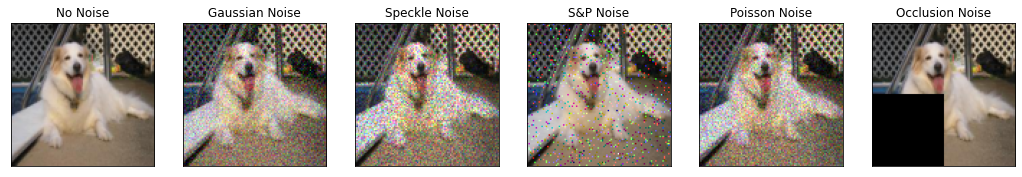

In [ ]:
fig_fig3, ax_fig3 = plt.subplots(ncols = 6, figsize = (18,3))

ax_fig3[0].imshow(im) # plot image
ax_fig3[0].set_title('No Noise') # add image title

ax_fig3[1].imshow(im_gauss)
ax_fig3[1].set_title('Gaussian Noise')

ax_fig3[2].imshow(im_speckle)
ax_fig3[2].set_title('Speckle Noise')

ax_fig3[3].imshow(im_sp)
ax_fig3[3].set_title('S&P Noise')

ax_fig3[4].imshow(im_poisson)
ax_fig3[4].set_title('Poisson Noise')

ax_fig3[5].imshow(im_occlusion)
ax_fig3[5].set_title('Occlusion Noise')

for ax in ax_fig3:
    ax.set_xticks([]) # remove axis labels for clear view
    ax.set_yticks([])
    
fig_fig3.savefig('noise_images.pdf', bbox_inches='tight', pad_inches=0.1)

# Training and evaluating ResNet18 models

Use the sample code below as a simple way to run each model (change variable names as required):

```python
gauss25_nette, results_gauss_25_nette = trainPipeline(gaussianT_25, "gaussian_25_nette.weights")
print('imagenette results: ', results_gauss_25_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_25_nette['val_acc'], '0.25 SSIM', 'Gaussian']], columns = cols))

gauss25_woof, results_gauss_25_woof = trainPipeline(gaussianT_25, "gaussian_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val')
print('imagewoof results: ', results_gauss_25_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_gauss_25_woof['val_acc'], '0.25 SSIM', 'Gaussian']], columns = cols))
```

These are the transforms which produce the SSIM level to train on, according to the paper, can be tuned if we find different results (Occlusion is left at 0.3 and not changed due to the values not being know/understood from the paper): 

In [ ]:
gaussianT_25, speckleT_25, spT_25, poissonT_25, occlusionT_25, noNoiseT = createTransforms((100,100), 0.0341, 0.3355, 0.0644, 0.5, 0.1046, 0.3)
gaussianT_50, speckleT_50, spT_50, poissonT_50, occlusionT_50, _ = createTransforms((100,100), 0.0085, 0.0515, 0.02305, 0.5, 0.0222, 0.3)
gaussianT_70, speckleT_70, spT_70, poissonT_70, occlusionT_70, _ = createTransforms((100,100), 0.0028, 0.0115, 0.01015, 0.5, 0.0064, 0.3)
gaussianT_80, speckleT_80, spT_80, poissonT_80, occlusionT_80, _ = createTransforms((100,100), 0.0016, 0.0054, 0.0067, 0.5, 0.0035, 0.3)
gaussianT_90, speckleT_90, spT_90, poissonT_90, occlusionT_90, _ = createTransforms((100,100), 0.0009, 0.0026, 0.00445, 0.5, 0.0019, 0.3)

Occlusion noise class may not be implemented correctly, use with caution!
Occlusion noise class may not be implemented correctly, use with caution!
Occlusion noise class may not be implemented correctly, use with caution!
Occlusion noise class may not be implemented correctly, use with caution!
Occlusion noise class may not be implemented correctly, use with caution!


## Helper Functions

In [ ]:
def createNewModel(n_classes = 10):
    model = torchvision.models.resnet18(pretrained = False) # instantiate randomly initialised ResNet18 model
    model.fc = nn.Linear(in_features = 512, out_features = n_classes, bias = True) # change output dim to number of classes
    return model

In [ ]:
def runModel(model, epochs, optimiser, loss_function, trainloader, valloader, use_torchbearer = False, load = True, weights = None):
    device = 'cuda' if torch.cuda.is_available() else 'cpu' # set device to gpu if available, otherwise use the cpu
    model.to(device) # load the model onto the specified device
    n_train = len(trainloader.dataset.imgs) # get the number of training images
    n_val = len(valloader.dataset.imgs) # get the number of validation images

    if not load:
    
      if use_torchbearer:
          # Construct a trial object with the model, optimiser and loss.
          # Also specify metrics we wish to compute.
          trial = torchbearer.Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)

          # Provide the data to the trial
          trial.with_generators(trainloader, val_generator=valloader)

          # Run `epochs` epochs of training
          trial.run(epochs=epochs)

          # test the performance
          results = trial.evaluate(data_key=torchbearer.VALIDATION_DATA)
          
          return model, results
      
      else:
          model.train()
          print('Training progress: ')
          for i in tqdm(range(epochs)):
              for inputs, targets in trainloader:
                  inputs, targets = inputs.to(device), targets.to(device) # load the data onto the device
                  
                  optimiser.zero_grad() # zero gradient for each batch so gradients don't accumulate
                  
                  outputs = model(inputs) # output of the model
                  loss = loss_function(outputs, targets) # value of the loss function
                  loss.backward() # differentiate the loss function w.r.t all the parameters that have gradients
                  
                  optimiser.step() # update the weights
                  
                          
    rl = 0.0 # set initial running loss to 0.0
    n_correct = 0 # counter for the number of correct predictions
    model.eval()
    if load:
      model.load_state_dict(torch.load(weights))

    model.eval()
    with torch.no_grad():
      print('Validation progress: ')        
      for inputs, targets in tqdm(valloader):
          inputs, targets = inputs.to(device), targets.to(device)
          
          outputs = model(inputs)
          rl += loss_function(outputs, targets).item() # increase the running loss (rl) inplace
          preds = torch.argmax(outputs, dim = 1) # get the predicted class
          n_correct += (preds == targets).float().sum() # count the number of correct predictions and add it to the total
          
      avg_loss = rl/n_val # the average loss over all validation samples
      acc = n_correct/n_val # accuracy over the validation samples
      
      results = {'val_loss': avg_loss, 'val_acc': acc.item()}
      
      return model, results
        

In [ ]:
def trainPipeline(transform, weights_file, epochs = 20, lr = 1e-4, train_loc = './imagenette2-160/train', val_loc = './imagenette2-160/val', use_torchbearer = False, save = True, load = False):
    weights_loc = '/content/drive/MyDrive/weights/' + weights_file
    TrainDataset = datasets.ImageFolder(train_loc, transform) # dataset object for the specified images

    noNoise_loc = transforms.Compose([
        transforms.Resize((100,100)),
        transforms.ToTensor(),
    ])

    ValDataset = datasets.ImageFolder(val_loc, noNoise_loc)


    Trainloader = DataLoader(TrainDataset, batch_size = 128, shuffle = True)
    Valloader = DataLoader(ValDataset, batch_size = 128, shuffle = True)

    model = createNewModel() # new ResNet model
    optimiser = optim.Adam(model.parameters(), lr=lr) # optimiser specified in Section 4 of the paper
    loss_function = nn.CrossEntropyLoss() # loss function assumed to be used
    # model, results = runModel(model, epochs, optimiser, loss_function, Trainloader, Valloader, use_torchbearer)
    model, results = runModel(model, epochs, optimiser, loss_function, Trainloader, Valloader, use_torchbearer, weights = weights_loc, load = load)
    if save:
      torch.save(model.state_dict(), weights_loc) # save the model weights

    return model, results
  

In [ ]:
def valPipeline(model, transform, loss_function = nn.CrossEntropyLoss(), val_loc = './imagenette2-160/val'):
    ValDataset = datasets.ImageFolder(val_loc, transform)
    Valloader = DataLoader(ValDataset, batch_size = 128, shuffle = True)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    n_val = len(Valloader.dataset.imgs) # get the number of validation images



    rl = 0.0 # set initial running loss to 0.0
    n_correct = 0 # counter for the number of correct predictions

    with torch.no_grad():
      for inputs, targets in Valloader:
          inputs, targets = inputs.to(device), targets.to(device)
          
          outputs = model(inputs)
          rl += loss_function(outputs, targets).item() # increase the running loss (rl) inplace
          preds = torch.argmax(outputs, dim = 1) # get the predicted class
          n_correct += (preds == targets).float().sum() # count the number of correct predictions and add it to the total
          
      avg_loss = rl/n_val # the average loss over all validation samples
      acc = n_correct/n_val # accuracy over the validation samples
      
      results = {'val_loss': avg_loss, 'val_acc': acc.item()}

    return results


## Noise type

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Noise Type']
imagenette_accs_df = pd.DataFrame(columns = cols)
imagewoof_accs_df = pd.DataFrame(columns = cols)

### No Noise (Baseline)

In [ ]:
none_nette, results_none_nette = trainPipeline(noNoiseT, "none_25_nette.weights", load = True)
print('imagenette results: ', results_none_nette)
none_woof, results_none_woof = trainPipeline(noNoiseT, "none_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_none_woof)

Validation progress: 



imagenette results:  {'val_loss': 0.01282437810472622, 'val_acc': 0.5877706408500671}
Validation progress: 



imagewoof results:  {'val_loss': 0.020988582684872987, 'val_acc': 0.3158564567565918}


### Gaussian

#### 0.25 SSIM

In [ ]:
gauss25_nette, results_gauss_25_nette = trainPipeline(gaussianT_25, "gaussian_25_nette.weights", load = True)
print('imagenette results: ', results_gauss_25_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_25_nette['val_acc'], '0.25 SSIM', 'Gaussian']], columns = cols))

gauss25_woof, results_gauss_25_woof = trainPipeline(gaussianT_25, "gaussian_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_gauss_25_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_gauss_25_woof['val_acc'], '0.25 SSIM', 'Gaussian']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.04276799256634561, 'val_acc': 0.22624202072620392}
Validation progress: 



imagewoof results:  {'val_loss': 0.03890672473999707, 'val_acc': 0.21506744623184204}


#### 0.5 SSIM

In [ ]:
gauss50_nette, results_gauss_50_nette = trainPipeline(gaussianT_50, "gaussian_50_nette.weights", load = True)
print('imagenette results: ', results_gauss_50_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_50_nette['val_acc'], '0.5 SSIM', 'Gaussian']], columns = cols))

gauss50_woof, results_gauss_50_woof = trainPipeline(gaussianT_50, "gaussian_50_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_gauss_50_woof)
imagewoof_accs_df=imagewoof_accs_df.append(pd.DataFrame([[results_gauss_50_woof['val_acc'], '0.5 SSIM', 'Gaussian']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.018100405286072166, 'val_acc': 0.5299362540245056}
Validation progress: 



imagewoof results:  {'val_loss': 0.024393122989307927, 'val_acc': 0.3189106583595276}


#### 0.7 SSIM

In [ ]:
gauss70_nette, results_gauss_70_nette = trainPipeline(gaussianT_70, "gaussian_70_nette.weights", load = True)
print('imagenette results: ', results_gauss_70_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_70_nette['val_acc'], '0.7 SSIM', 'Gaussian']], columns = cols))

gauss70_woof, results_gauss_70_woof = trainPipeline(gaussianT_70, "gaussian_70_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_gauss_70_woof)
imagewoof_accs_df=imagewoof_accs_df.append(pd.DataFrame([[results_gauss_70_woof['val_acc'], '0.7 SSIM', 'Gaussian']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.021464982366865608, 'val_acc': 0.4963057041168213}
Validation progress: 



imagewoof results:  {'val_loss': 0.023081418969728894, 'val_acc': 0.3237465023994446}


#### 0.8 SSIM

In [ ]:
gauss80_nette, results_gauss_80_nette = trainPipeline(gaussianT_80, "gaussian_80_nette.weights", load = True)
print('imagenette results: ', results_gauss_80_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_80_nette['val_acc'], '0.8 SSIM', 'Gaussian']], columns = cols))

gauss80_woof, results_gauss_80_woof = trainPipeline(gaussianT_80, "gaussian_80_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_gauss_80_woof)
imagewoof_accs_df=imagewoof_accs_df.append(pd.DataFrame([[results_gauss_80_woof['val_acc'], '0.8 SSIM', 'Gaussian']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.015441640805286967, 'val_acc': 0.5617834329605103}
Validation progress: 



imagewoof results:  {'val_loss': 0.023357553923818775, 'val_acc': 0.32654619216918945}


#### 0.9 SSIM

In [ ]:
gauss90_nette, results_gauss_90_nette = trainPipeline(gaussianT_90, "gaussian_90_nette.weights", load = True)
print('imagenette results: ', results_gauss_90_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_gauss_90_nette['val_acc'], '0.9 SSIM', 'Gaussian']], columns = cols))

gauss90_woof, results_gauss_90_woof = trainPipeline(gaussianT_90, "gaussian_90_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_gauss_90_woof)
imagewoof_accs_df=imagewoof_accs_df.append(pd.DataFrame([[results_gauss_90_woof['val_acc'], '0.9 SSIM', 'Gaussian']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.012487528582287442, 'val_acc': 0.609426736831665}
Validation progress: 



imagewoof results:  {'val_loss': 0.03145415790817094, 'val_acc': 0.25426316261291504}


### Speckle

#### 0.25 SSIM

In [ ]:
speckle25_nette, results_speckle_25_nette = trainPipeline(speckleT_25, "speckle_25_nette.weights", load = True)
print('imagenette results: ', results_speckle_25_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_speckle_25_nette['val_acc'], '0.25 SSIM', 'Speckle']], columns = cols))

speckle25_woof, results_speckle_25_woof = trainPipeline(speckleT_25, "speckle_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_speckle_25_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_speckle_25_woof['val_acc'], '0.25 SSIM', 'Speckle']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.036923114873801066, 'val_acc': 0.31082800030708313}
Validation progress: 



imagewoof results:  {'val_loss': 0.03424070463377151, 'val_acc': 0.23364722728729248}


#### 0.5 SSIM

In [ ]:
speckle50_nette, results_speckle_50_nette = trainPipeline(speckleT_50, "speckle_50_nette.weights", load = True)
print('imagenette results: ', results_speckle_50_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_speckle_50_nette['val_acc'], '0.5 SSIM', 'Speckle']], columns = cols))

speckle50_woof, results_speckle_50_woof = trainPipeline(speckleT_25, "speckle_50_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_speckle_50_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_speckle_50_woof['val_acc'], '0.5 SSIM', 'Speckle']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.019783818008034092, 'val_acc': 0.5149044394493103}
Validation progress: 



imagewoof results:  {'val_loss': 0.038808577356219565, 'val_acc': 0.22168490290641785}


#### 0.7 SSIM

In [ ]:
speckle70_nette, results_speckle_70_nette = trainPipeline(speckleT_70, "speckle_70_nette.weights", load = True)
print('imagenette results: ', results_speckle_70_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_speckle_70_nette['val_acc'], '0.7 SSIM', 'Speckle']], columns = cols))

speckle70_woof, results_speckle_70_woof = trainPipeline(speckleT_70, "speckle_70_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_speckle_70_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_speckle_70_woof['val_acc'], '0.7 SSIM', 'Speckle']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.012438273703216747, 'val_acc': 0.6382165551185608}
Validation progress: 



imagewoof results:  {'val_loss': 0.022595394049081587, 'val_acc': 0.3270552158355713}


#### 0.8 SSIM

In [ ]:
speckle80_nette, results_speckle_80_nette = trainPipeline(speckleT_80, "speckle_80_nette.weights", load = True)
print('imagenette results: ', results_speckle_80_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_speckle_80_nette['val_acc'], '0.8 SSIM', 'Speckle']], columns = cols))

speckle80_woof, results_speckle_80_woof = trainPipeline(speckleT_80, "speckle_80_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_speckle_80_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_speckle_80_woof['val_acc'], '0.8 SSIM', 'Speckle']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.015120544463965543, 'val_acc': 0.5987260937690735}
Validation progress: 



imagewoof results:  {'val_loss': 0.02414087661807244, 'val_acc': 0.32781878113746643}


#### 0.9 SSIM

In [ ]:
speckle90_nette, results_speckle_90_nette = trainPipeline(speckleT_90, "speckle_90_nette.weights", load = True)
print('imagenette results: ', results_speckle_90_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_speckle_90_nette['val_acc'], '0.9 SSIM', 'Speckle']], columns = cols))

speckle90_woof, results_speckle_90_woof = trainPipeline(speckleT_90, "speckle_90_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_speckle_90_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_speckle_90_woof['val_acc'], '0.9 SSIM', 'Speckle']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.01249803558276717, 'val_acc': 0.6048407554626465}
Validation progress: 



imagewoof results:  {'val_loss': 0.021648727503402992, 'val_acc': 0.33799949288368225}


### Salt & Pepper

#### 0.25 SSIM

In [ ]:
sp25_nette, results_sp_25_nette = trainPipeline(spT_25, "sp_25_nette.weights", load = True)
print('imagenette results: ', results_sp_25_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_sp_25_nette['val_acc'], '0.25 SSIM', 'S&P']], columns = cols))

sp25_woof, results_sp_25_woof = trainPipeline(spT_25, "sp_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_sp_25_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_sp_25_woof['val_acc'], '0.25 SSIM', 'S&P']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.018230225720982644, 'val_acc': 0.5202547311782837}
Validation progress: 



imagewoof results:  {'val_loss': 0.023277891413435496, 'val_acc': 0.33469074964523315}


#### 0.5 SSIM

In [ ]:
sp50_nette, results_sp_50_nette = trainPipeline(spT_50, "sp_50_nette.weights", load = True)
print('imagenette results: ', results_sp_50_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_sp_50_nette['val_acc'], '0.5 SSIM', 'S&P']], columns = cols))

sp50_woof, results_sp_50_woof = trainPipeline(spT_50, "sp_50_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_sp_50_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_sp_50_woof['val_acc'], '0.5 SSIM', 'S&P']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.014859723376620348, 'val_acc': 0.5921018719673157}
Validation progress: 



imagewoof results:  {'val_loss': 0.022345058303293183, 'val_acc': 0.34308984875679016}


#### 0.7 SSIM

In [ ]:
sp70_nette, results_sp_70_nette = trainPipeline(spT_70, "sp_70_nette.weights", load = True)
print('imagenette results: ', results_sp_70_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_sp_70_nette['val_acc'], '0.7 SSIM', 'S&P']], columns = cols))

sp70_woof, results_sp_70_woof = trainPipeline(spT_70, "sp_70_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_sp_70_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_sp_70_woof['val_acc'], '0.7 SSIM', 'S&P']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.011781041637347762, 'val_acc': 0.631847083568573}
Validation progress: 



imagewoof results:  {'val_loss': 0.022394363678087257, 'val_acc': 0.32781878113746643}


#### 0.8 SSIM

In [ ]:
sp80_nette, results_sp_80_nette = trainPipeline(spT_80, "sp_80_nette.weights", load = True)
print('imagenette results: ', results_sp_80_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_sp_80_nette['val_acc'], '0.8 SSIM', 'S&P']], columns = cols))

sp80_woof, results_sp_80_woof = trainPipeline(spT_80, "sp_80_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_sp_80_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_sp_80_woof['val_acc'], '0.8 SSIM', 'S&P']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.014311571910882451, 'val_acc': 0.590828001499176}
Validation progress: 



imagewoof results:  {'val_loss': 0.022092047766833305, 'val_acc': 0.3499618172645569}


#### 0.9 SSIM

In [ ]:
sp90_nette, results_sp_90_nette = trainPipeline(spT_90, "sp_90_nette.weights", load = True)
print('imagenette results: ', results_sp_90_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_sp_90_nette['val_acc'], '0.9 SSIM', 'S&P']], columns = cols))

sp90_woof, results_sp_90_woof = trainPipeline(spT_90, "sp_90_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_sp_90_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_sp_90_woof['val_acc'], '0.9 SSIM', 'S&P']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.01369698053712298, 'val_acc': 0.5974522233009338}
Validation progress: 



imagewoof results:  {'val_loss': 0.022347438848179454, 'val_acc': 0.3369814157485962}


### Poisson

#### 0.25 SSIM

In [ ]:
poisson25_nette, results_poisson_25_nette = trainPipeline(poissonT_25, "poisson_25_nette.weights", load = True)
print('imagenette results: ', results_poisson_25_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_poisson_25_nette['val_acc'], '0.25 SSIM', 'Poisson']], columns = cols))

poisson25_woof, results_poisson_25_woof = trainPipeline(poissonT_25, "poisson_25_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_poisson_25_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_poisson_25_woof['val_acc'], '0.25 SSIM', 'Poisson']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.029136068319818777, 'val_acc': 0.3243311941623688}
Validation progress: 



imagewoof results:  {'val_loss': 0.03441194057100509, 'val_acc': 0.22830235958099365}


#### 0.5 SSIM

In [ ]:
poisson50_nette, results_poisson_50_nette = trainPipeline(poissonT_50, "poisson_50_nette.weights", load = True)
print('imagenette results: ', results_poisson_50_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_poisson_50_nette['val_acc'], '0.5 SSIM', 'Poisson']], columns = cols))

poisson50_woof, results_poisson_50_woof = trainPipeline(poissonT_50, "poisson_50_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_poisson_50_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_poisson_50_woof['val_acc'], '0.5 SSIM', 'Poisson']], columns = cols))

Validation progress: 



imagenette results:  {'val_loss': 0.017418257810507612, 'val_acc': 0.541146457195282}
Validation progress: 



imagewoof results:  {'val_loss': 0.02839419768341445, 'val_acc': 0.29727664589881897}


#### 0.7 SSIM

In [ ]:
poisson70_nette, results_poisson_70_nette = trainPipeline(poissonT_70, "poisson_70_nette.weights")
print('imagenette results: ', results_poisson_70_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_poisson_70_nette['val_acc'], '0.7 SSIM', 'Poisson']], columns = cols))

poisson70_woof, results_poisson_70_woof = trainPipeline(poissonT_70, "poisson_70_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_poisson_70_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_poisson_70_woof['val_acc'], '0.7 SSIM', 'Poisson']], columns = cols))

Training progress: 



Validation progress: 



imagenette results:  {'val_loss': 0.017485665910562893, 'val_acc': 0.5337579250335693}
Validation progress: 



imagewoof results:  {'val_loss': 0.022528246541944404, 'val_acc': 0.3415627181529999}


#### 0.8 SSIM

In [ ]:
poisson80_nette, results_poisson_80_nette = trainPipeline(poissonT_80, "poisson_80_nette.weights")
print('imagenette results: ', results_poisson_80_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_poisson_80_nette['val_acc'], '0.8 SSIM', 'Poisson']], columns = cols))

poisson80_woof, results_poisson_80_woof = trainPipeline(poissonT_80, "poisson_80_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_poisson_80_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_poisson_80_woof['val_acc'], '0.8 SSIM', 'Poisson']], columns = cols))

Training progress: 



Validation progress: 



imagenette results:  {'val_loss': 0.014328703971425438, 'val_acc': 0.5775795578956604}
Validation progress: 



imagewoof results:  {'val_loss': 0.02787278759840579, 'val_acc': 0.2850598096847534}


#### 0.9 SSIM

In [ ]:
poisson90_nette, results_poisson_90_nette = trainPipeline(poissonT_90, "poisson_90_nette.weights")
print('imagenette results: ', results_poisson_90_nette)
imagenette_accs_df=imagenette_accs_df.append(pd.DataFrame([[results_poisson_90_nette['val_acc'], '0.9 SSIM', 'Poisson']], columns = cols))

poisson90_woof, results_poisson_90_woof = trainPipeline(poissonT_90, "poisson_90_woof.weights", train_loc = './imagewoof2-160/train', val_loc = './imagewoof2-160/val', load = True)
print('imagewoof results: ', results_poisson_90_woof)
imagewoof_accs_df = imagewoof_accs_df.append(pd.DataFrame([[results_poisson_90_woof['val_acc'], '0.9 SSIM', 'Poisson']], columns = cols))

Training progress: 



Validation progress: 



imagenette results:  {'val_loss': 0.011724250665895499, 'val_acc': 0.6341400742530823}
Validation progress: 



imagewoof results:  {'val_loss': 0.021789911291501575, 'val_acc': 0.3288368582725525}


## Bringing the results together

In [ ]:
imagenette_accs_df.to_csv('imagenette_accs_df.csv', index=False) # save the csv file
imagewoof_accs_df.to_csv('imagewoof_accs_df.csv', index=False)

In [ ]:
imagenette_accs_df = pd.read_csv('imagenette_accs_df.csv')
imagewoof_accs_df = pd.read_csv('imagewoof_accs_df.csv')

### Figures 4 and 5

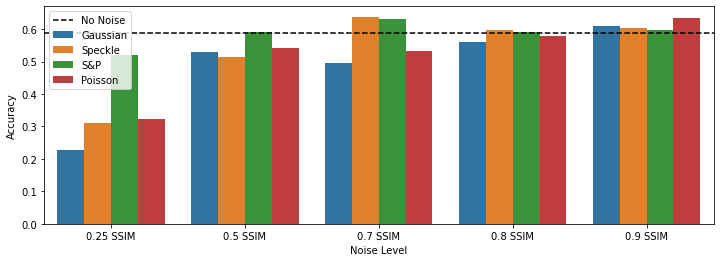

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(data = imagenette_accs_df, x = 'Noise Level', y = 'Accuracy', hue = 'Noise Type')
plt.axhline(results_none_nette['val_acc'], linestyle = '--', c ='k', label = 'No Noise')
plt.legend()

plt.savefig('output/plots/acc_imagenette.pdf', bbox_inches='tight', pad_inches=0.1)

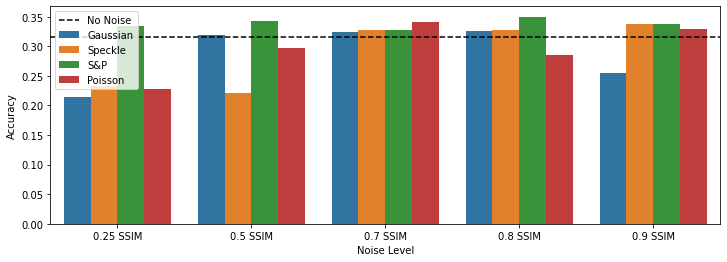

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(data = imagewoof_accs_df, x = 'Noise Level', y = 'Accuracy', hue = 'Noise Type')
plt.axhline(results_none_woof['val_acc'], linestyle = '--', c ='k', label = 'No Noise')
plt.legend()

plt.savefig('output/plots/acc_imagewoof.pdf', bbox_inches='tight', pad_inches=0.1)

### Figures 6 and 7

In [ ]:
model_type = ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM','No Noise - Baseline'] # noise level of model

In [ ]:
gauss_models_nette = [gauss25_nette, gauss50_nette, gauss70_nette, gauss80_nette, gauss90_nette,none_nette] # list of gaussian models for imagenette dataset
speckle_models_nette = [speckle25_nette, speckle50_nette, speckle70_nette, speckle80_nette, speckle90_nette,none_nette]
sp_models_nette = [sp25_nette, sp50_nette, sp70_nette, sp80_nette, sp90_nette,none_nette]
poisson_models_nette = [poisson25_nette, poisson50_nette, poisson70_nette, poisson80_nette, poisson90_nette,none_nette]

In [ ]:
gauss_models_woof = [gauss25_woof, gauss50_woof, gauss70_woof, gauss80_woof, gauss90_woof,none_woof]
speckle_models_woof = [speckle25_woof, speckle50_woof, speckle70_woof, speckle80_woof, speckle90_woof,none_woof]
sp_models_woof = [sp25_woof, sp50_woof, sp70_woof, sp80_woof, sp90_woof,none_woof]
poisson_models_woof = [poisson25_woof, poisson50_woof, poisson70_woof, poisson80_woof, poisson90_woof,none_woof]

#### Figure 6

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
gauss_robust_nette = pd.DataFrame(columns = cols) # create the DataFrame to create plot from
for trans, noise in tqdm(zip([gaussianT_25, gaussianT_50, gaussianT_70, gaussianT_80, gaussianT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(gauss_models_nette, model_type):
    res = valPipeline(m, trans)
    gauss_robust_nette = gauss_robust_nette.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))


In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
speckle_robust_nette = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([speckleT_25, speckleT_50, speckleT_70, speckleT_80, speckleT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(speckle_models_nette, model_type):
    res = valPipeline(m, trans)
    speckle_robust_nette = speckle_robust_nette.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
sp_robust_nette = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([spT_25, spT_50, spT_70, spT_80, spT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(sp_models_nette, model_type):
    res = valPipeline(m, trans)
    sp_robust_nette = sp_robust_nette.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
poisson_robust_nette = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([poissonT_25, poissonT_50, poissonT_70, poissonT_80, poissonT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(poisson_models_nette, model_type):
    res = valPipeline(m, trans)
    poisson_robust_nette = poisson_robust_nette.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
gauss_robust_nette = pd.read_csv('gauss_robust_nette_df.csv')
speckle_robust_nette = pd.read_csv('speckle_robust_nette_df.csv')
sp_robust_nette = pd.read_csv('sp_robust_nette_df.csv')
poisson_robust_nette = pd.read_csv('poisson_robust_nette_df.csv')

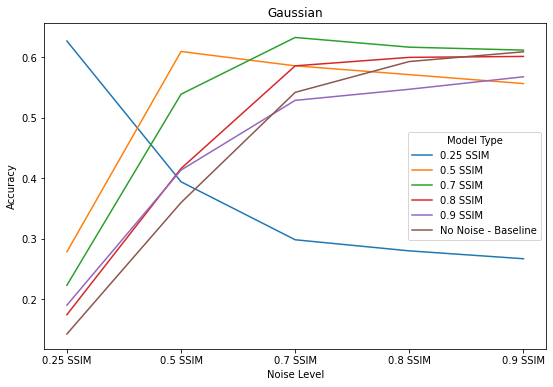

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = gauss_robust_nette, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Gaussian')
plt.savefig('output/plots/gauss_robust_nette.pdf', bbox_inches='tight', pad_inches=0.1)
# gauss_robust_nette.to_csv('output/csv/gauss_robust_nette_df.csv')

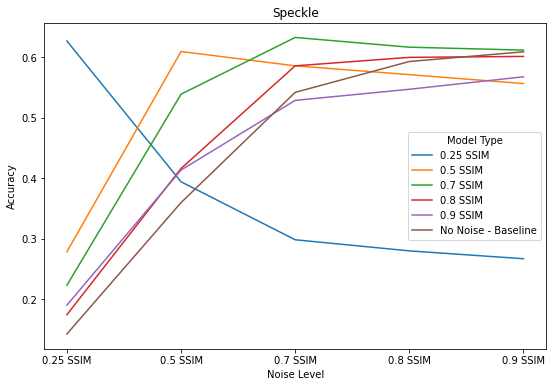

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = speckle_robust_nette, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Speckle')
plt.savefig('output/plots/speckle_robust_nette.pdf', bbox_inches='tight', pad_inches=0.1)
# gauss_robust_nette.to_csv('output/csv/speckle_robust_nette_df.csv')

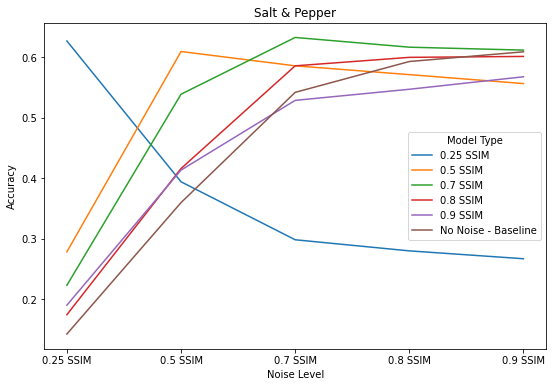

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = sp_robust_nette, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Salt & Pepper')
plt.savefig('output/plots/sp_robust_nette.pdf', bbox_inches='tight', pad_inches=0.1)
# gauss_robust_nette.to_csv('output/csv/sp_robust_nette_df.csv')

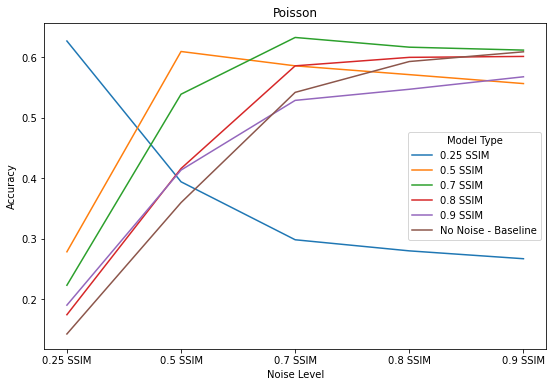

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = poisson_robust_nette, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Poisson')
plt.savefig('output/plots/poisson_robust_nette.pdf', bbox_inches='tight', pad_inches=0.1)
# gauss_robust_nette.to_csv('output/csv/poisson_robust_nette_df.csv')

#### Figure 7

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
gauss_robust_woof = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([gaussianT_25, gaussianT_50, gaussianT_70, gaussianT_80, gaussianT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(gauss_models_woof, model_type):
    res = valPipeline(m, trans, val_loc='./imagewoof2-160/val')
    gauss_robust_woof = gauss_robust_woof.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
speckle_robust_woof = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([speckleT_25, speckleT_50, speckleT_70, speckleT_80, speckleT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(speckle_models_woof, model_type):
    res = valPipeline(m, trans, val_loc='./imagewoof2-160/val')
    speckle_robust_woof = speckle_robust_woof.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
sp_robust_woof = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([spT_25, spT_50, spT_70, spT_80, spT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(sp_models_woof, model_type):
    res = valPipeline(m, trans, val_loc='./imagewoof2-160/val')
    sp_robust_woof = sp_robust_woof.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
cols = ['Accuracy', 'Noise Level', 'Model Type']
poisson_robust_woof = pd.DataFrame(columns = cols)
for trans, noise in tqdm(zip([poissonT_25, poissonT_50, poissonT_70, poissonT_80, poissonT_90], ['0.25 SSIM', '0.5 SSIM','0.7 SSIM','0.8 SSIM','0.9 SSIM'])):
  for m, t in zip(poisson_models_woof, model_type):
    res = valPipeline(m, trans, val_loc='./imagewoof2-160/val')
    poisson_robust_woof = poisson_robust_woof.append(pd.DataFrame([[res['val_acc'], noise, t]], columns=cols))

In [ ]:
gauss_robust_woof = pd.read_csv('gauss_robust_woof_df.csv')
speckle_robust_woof = pd.read_csv('speckle_robust_woof_df.csv')
sp_robust_woof = pd.read_csv('sp_robust_woof_df.csv')
poisson_robust_woof = pd.read_csv('poisson_robust_woof_df.csv')

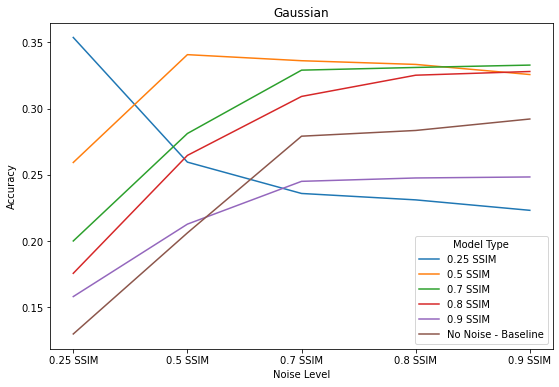

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = gauss_robust_woof, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Gaussian')
plt.savefig('output/plots/gauss_robust_woof.pdf', bbox_inches='tight', pad_inches=0.1)
# gauss_robust_woof.to_csv('output/csv/gauss_robust_woof_df.csv')

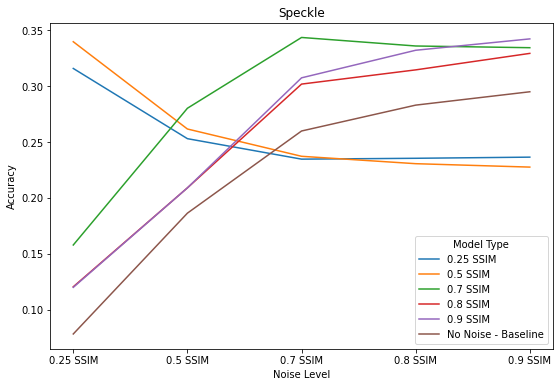

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = speckle_robust_woof, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Speckle')
plt.savefig('output/plots/speckle_robust_woof.pdf', bbox_inches='tight', pad_inches=0.1)
# speckle_robust_woof.to_csv('output/csv/speckle_robust_woof_df.csv')

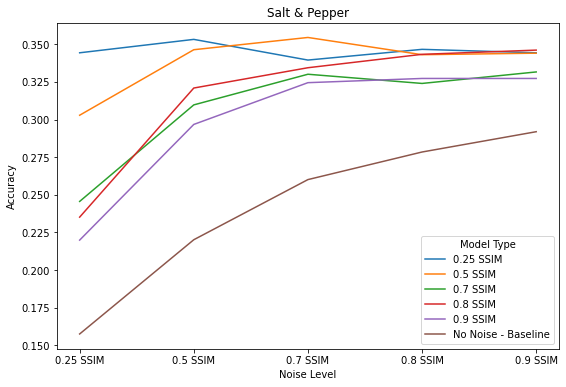

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = sp_robust_woof, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Salt & Pepper')
plt.savefig('output/plots/sp_robust_woof.pdf', bbox_inches='tight', pad_inches=0.1)
# sp_robust_woof.to_csv('output/csv/sp_robust_woof_df.csv')

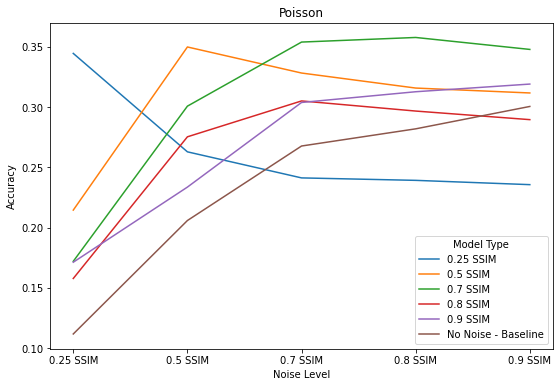

In [ ]:
plt.figure(figsize = (9,6))
sns.lineplot(data = poisson_robust_woof, x = 'Noise Level', y = 'Accuracy', hue = 'Model Type')
plt.title('Poisson')
plt.savefig('output/plots/poisson_robust_woof.pdf', bbox_inches='tight', pad_inches=0.1)
# poisson_robust_woof.to_csv('output/csv/poisson_robust_woof_df.csv')